Introdução

Implementar um algoritmo de machine learning capaz de separar grandes quantidades de imagens, em tamanho grande, de acordo com suas respectivas categorias.

Perceber os conceitos de redes neurais, os pré-requisitos para correta implementação e seus trade-offs.



Sobre o Dataset

Imagens de diferentes paisagens, classificadas em 6 diferentes categorias:
- Buildings
- Forest
- Glacier
- Mountain
- Sea
- Street

O dataset possui aproximadamente 25k imagens no total, divididas em:
- 14k para treino
- 3k para teste
- 7k para predição

O objetivo principal neste notebook é implementar uma rede neural, utilizando tensorFlow e a API Keras.

As imagens tem dimensão de 150 x 150.

Seguindo o tutorial: https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras, estarei seguindo a seguinte ordem lógica para aprendizado:

1. Verificar e importar as bibliotecas necessárias
2. Importar o dataset, visualizar amostras aleatórias e realizar pré-processamento
3. Implementar um modelo simples e inicial de CNN, e validar sua performance
4. Verificar os resultados, a implementação e possíveis melhorias.

Importando as bibliotecas necessárias para a implementação

In [1]:
#%% Importing packages
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd

Definição de labels e definição do tamanho de cada imagem.

In [2]:

class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

Carregando o dataset

Nota: importante realizar o download do dataset. O tamanho total é consideravelmente grande.

Extrair os respectivos datasets para a pasta input, ou então alterar o path, conforme necessário.

Seguindo o tutorial, é desenvolvida uma função para realizar o carregamento do dataset, chamada load_data.

In [3]:
#%%LOADING THE DATA
"""
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """

def load_data():
    
    datasets = ['./input/seg_train/seg_train', './input/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

Utilizar a função load_data(), para se obter os dados de treino e teste.

Em seguida, embaralhar os dados, de forma randômica.

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

Loading ./input/seg_train/seg_train


100%|██████████| 2382/2382 [00:02<00:00, 832.52it/s]


Loading ./input/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 865.95it/s]


Explorando o dataset

- Verificar as amostras de treino e teste
- Verificar o tamanho das imagens
- Verificar a proporção e ocorrência de cada categoria

In [5]:

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


Visualização de dados

- Proporção de imagens de treino e teste, distribuídas para cada categoria
- Proporção de imagens por categoria, para verificar se os dados estão balanceados.

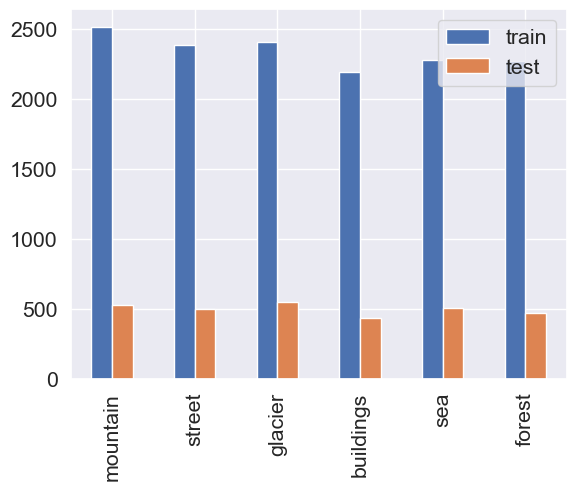

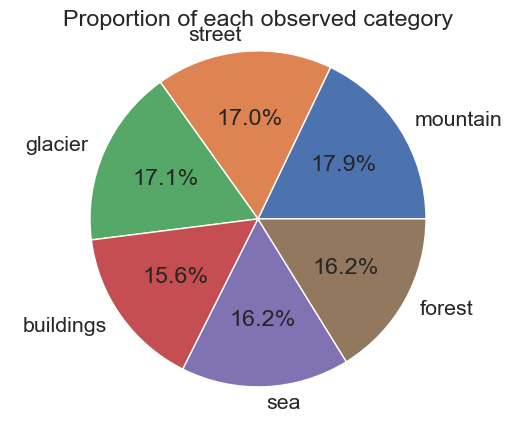

In [6]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
            'test': test_counts}, 
            index=class_names
            ).plot.bar()
plt.show()

plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

train_images = train_images / 255.0 
test_images = test_images / 255.0

Visualizar imagens, de maneira aleatória

É definida uma função específica para escolha de uma imagem aleatória do array de imagens e sua correspondente label, de acordo com o index.

Também é definida outra função para a visualização de 25 imagens de forma aleatória, chamada display_examples.


In [7]:
"""
    Display a random image from the images array and its correspond label from the labels array.
"""
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
    

Utilizara função display_random_image.

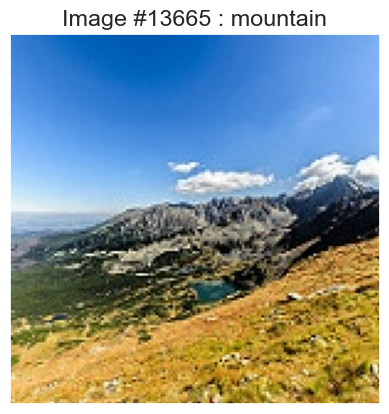

In [8]:
display_random_image(class_names, train_images, train_labels)

In [9]:
"""
    Display 25 images from the images array with its corresponding labels
"""
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    

Executar a função display_examples.

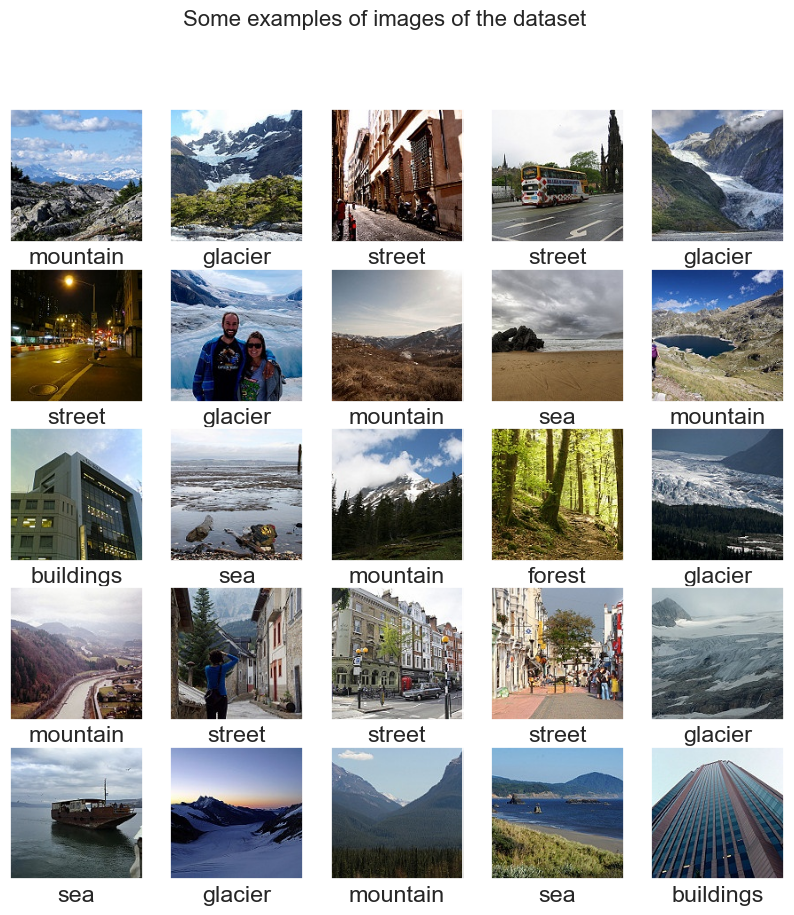

In [10]:
display_examples(class_names, train_images, train_labels)


Criação de modelo CNN básico

De acordo com a documentação do Keras, a variável model é inicializada como um modelo sequencial, adicionando camadas de forma linear, seguindo a ordem dos itens do array, do menor ao maior índice.

Características do modelo

Camadas convolucionais iniciais:
- A primeira camada convolucional 2D é adicionada, com 32 filtros, cada um no tamanho de 3x3 e com uma função de ativação ReLU. Também passamos como argumento para esta camada de entrada as dimensões de input (imagens), com suas respectivas dimensões e o canal de cor (RGB).
- Camada seguinte, de duas dimensões e tamanho 2x2, chamada MaxPooling, para redução de dimensão espacial do dado.

Camadas convolucionais adicionais:
- Seguindo modelos já conhecidos e testados, conforme indicação.

Camada Flat:
- Transforma a saída da camada anterior, de dimensão 2D para um vetor de dimensão 1D, como forma de preparo para as camadas seguintes.

Camadas Densas:
- Adição de 128 camadas com função de ativação ReLU
- Camada de saída, de acordo com o número de classes do problema de classificação, neste caso, 6.



In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Compilação do modelo CNN inicial e suas respectivas camadas

- optimizer='adam': O otimizador é o algoritmo usado para atualizar os pesos da rede neural durante seu treinamento. Neste caso, 'adam' refere-se ao algoritmo de otimização gradient descent
- loss='sparse_categorical_crossentropy': A função de perda é uma medida de quão bem o modelo está se saindo. 'sparse_categorical_crossentropy' é um tipo específico de função de perda usada para tarefas de classificação multi-classe quando os rótulos são fornecidos como inteiros. Ela calcula a perda de entropia cruzada entre a distribuição de probabilidade prevista e a verdadeira distribuição de probabilidade das classes.
- metrics=['accuracy']: As métricas são usadas para avaliar o desempenho do modelo. Neste caso, a métrica 'accuracy' é usada para monitorar a precisão da classificação do modelo durante o treinamento e a avaliação. Ela calcula a proporção de imagens classificadas corretamente em relação ao número total de imagens.

In [12]:
model.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics=['accuracy'])

Seguindo a lógica já vista em outros modelos de classificação, após a análise dos dados, pré-processamento, realizaremos o treino do modelo e sua validação com os dados de teste e predição, verificando a nota de desempenho, relacionado com as imagens corretamente classificadas em relação ao total de imagens.

Fit dos dados de treino

In [13]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)


Epoch 1/20


88/88 [==============================] - 28s 289ms/step - loss: 1.1633 - accuracy: 0.5701 - val_loss: 0.9386 - val_accuracy: 0.6477
Epoch 2/20
88/88 [==============================] - 26s 295ms/step - loss: 0.7526 - accuracy: 0.7249 - val_loss: 0.7026 - val_accuracy: 0.7478
Epoch 3/20
88/88 [==============================] - 27s 308ms/step - loss: 0.6164 - accuracy: 0.7828 - val_loss: 0.6839 - val_accuracy: 0.7563
Epoch 4/20
88/88 [==============================] - 26s 298ms/step - loss: 0.4883 - accuracy: 0.8347 - val_loss: 0.6210 - val_accuracy: 0.7852
Epoch 5/20
88/88 [==============================] - 25s 281ms/step - loss: 0.3616 - accuracy: 0.8783 - val_loss: 0.6291 - val_accuracy: 0.7877
Epoch 6/20
88/88 [==============================] - 25s 282ms/step - loss: 0.2777 - accuracy: 0.9073 - val_loss: 0.6995 - val_accuracy: 0.7688
Epoch 7/20
88/88 [==============================] - 25s 284ms/step - loss: 0.1802 - accuracy: 0.9472 - val_loss: 0.7128 - val_accuracy: 0.78

Avaliar desempenho

Com uma função específica para avaliar o desempenho do modelo, após seu treino com o dataset de treino.

In [14]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    

Utilizando a função de verificação de desempenho, com o modelo treinado, armazenado na variável history.

{'loss': [1.163262128829956, 0.7526459693908691, 0.6164373755455017, 0.4882713854312897, 0.3615661859512329, 0.27766647934913635, 0.18019579350948334, 0.12200544774532318, 0.08255735039710999, 0.04999399557709694, 0.0377991683781147, 0.03079133667051792, 0.028607260435819626, 0.022073140367865562, 0.016077324748039246, 0.058948930352926254, 0.02047150209546089, 0.01337878406047821, 0.01427740603685379, 0.01160859502851963], 'accuracy': [0.5700543522834778, 0.7249487638473511, 0.7827558517456055, 0.8346842527389526, 0.8783290386199951, 0.9072771072387695, 0.9471809267997742, 0.9674000144004822, 0.9795136451721191, 0.9897568225860596, 0.9943885207176208, 0.9952792525291443, 0.9954573512077332, 0.9968824982643127, 0.9980404376983643, 0.9860158562660217, 0.996437132358551, 0.998485803604126, 0.9983966946601868, 0.998753011226654], 'val_loss': [0.938604474067688, 0.702580988407135, 0.6838985681533813, 0.6210214495658875, 0.6291237473487854, 0.6995483040809631, 0.712817370891571, 0.783235192

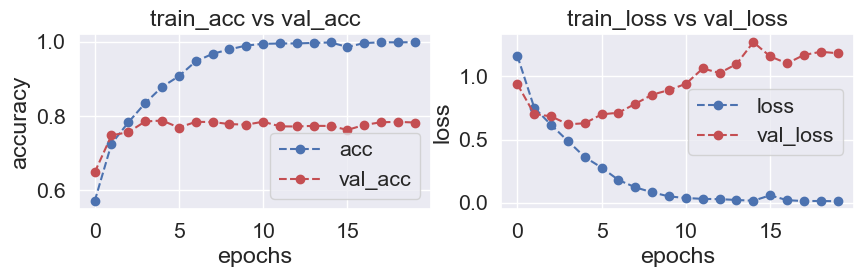

In [15]:
print(history.history)
plot_accuracy_loss(history)


Validação com os dados de teste

In [16]:
test_loss = model.evaluate(test_images, test_labels)
print(test_loss)

94/94 [==============================] - 2s 21ms/step - loss: 1.1723 - accuracy: 0.7833
[1.1723331212997437, 0.7833333611488342]


Verificar o desempenho do modelo em imagens aleatórias

94/94 [==============================] - 2s 22ms/step


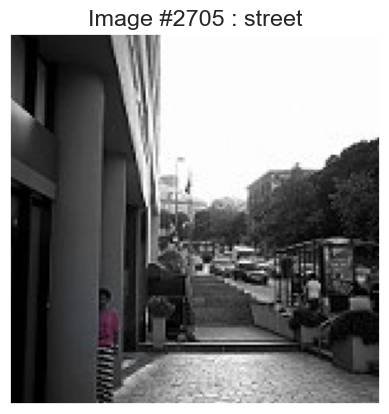

In [17]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

Análise de erros na predição

Para possibilitar a avaliação do modelo nas imagens em que classificou de forma erronea, é definida uma função para visualizar 25 imagens do conjunto de imagens com classificação falha.

Em seguida, utilizamos a função confusion_matrix para verificar a correlação entre as imagens de teste e predição, através do label, já que as imagens podem ser acessadas através de index.

In [18]:
#%% MISLABELED IMAGES
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

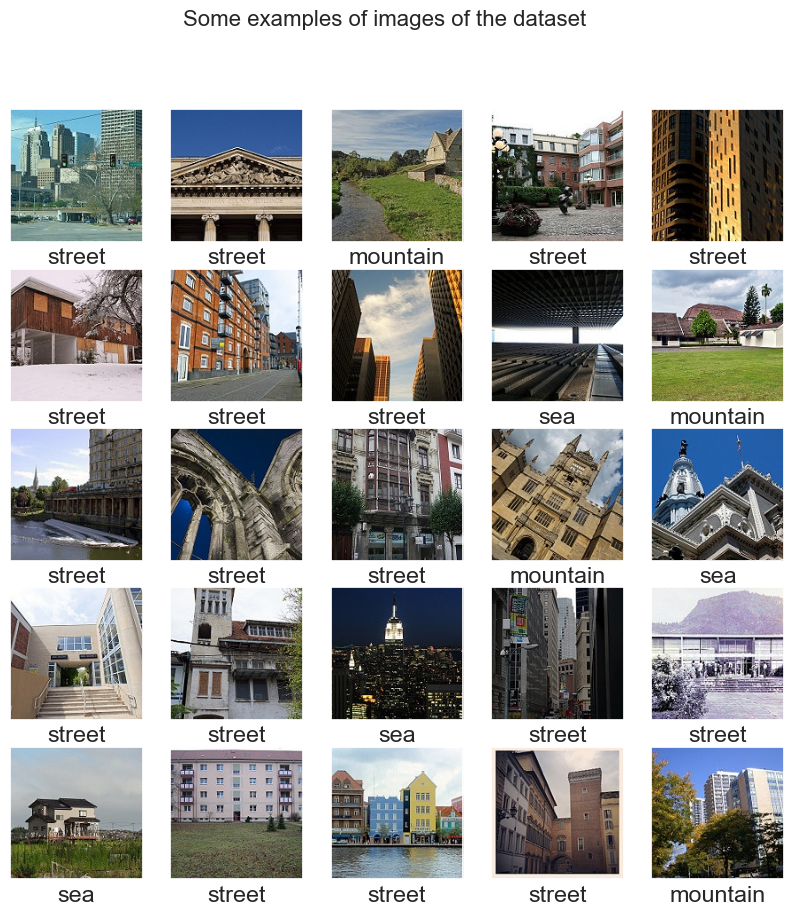

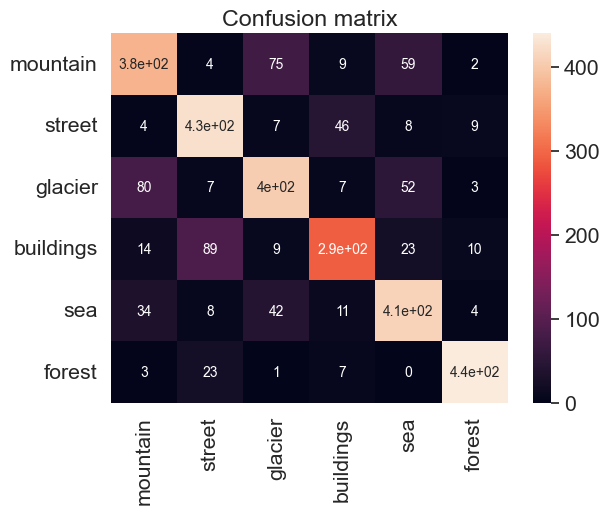

In [19]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
    annot_kws={"size": 10}, 
    xticklabels=class_names, 
    yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Conclusão

De acordo com a matrix de correlação, é possível verificar que o modelo possui dificuldades em reconhecer imagens da categoria building, que possuem streets, assim como dificuldade em distinguir entre mar, geleiras e montanhas. Porém tem melhor desempenho em distinguir imagens de florestas.

SECÇÃO DE MELHORIA DE RESULTADOS (03 DE FEVEREIRO DE 2024)

Complemento da implementação do modelo mais simples, em que nota-se dificuldades do modelo em reconhecimento de imagens da categoria "building" com características de outras categorias, nomeadas "street", "glacier" e "mountains".

Para isso, o próximo passo para análise de melhoria de desempenho é a utilização do VGG16, que consiste na extração de features baseada em modelo treinado no ImageNet

O tutorial se baseou no modelo https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/



Importando os pacotes necessários para a implementação com o VGG

In [20]:
# IMPORTING REQUIRED PACKAGES
# RUN THIS BLOCK OF CODE ONCE !!
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn import decomposition
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten
from sklearn.metrics import accuracy_score


In [21]:
#DEFINING VGG16 MODEL
#CREATING A NEW INSTANCE 
vgg_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


VGG16 

- O que é:
VGG é o nome de mais um dos diferentes modelos de rede neural existentes, criado por Visual Graphics Group (VGG) na universidade de Oxford. Suas principais características são: simplicidade e profundidade (camadas) da rede. Ao total são 16 camadas com o parâmetro de peso (VGG16). Este modelo tem sido utilizado amplamente nas aplicações de machine learning, principalmente reconhecimento de imagens e detecção de movimentos.

Assim como foi realizado para todos os outros modelos, tanto para regressão ou classificação, a metodologia de trabalho continua igual:
- Criar a instância de modelo
- Treinar esse modelo com um conjunto devidamente separado para testes
- Utilizar o modelo treinado para precição, com um conjunto devidamente separado para avaliação de desempenho
- Em seguida, avaliar o desempenho

In [22]:
# TRAINING SECTION
train_features = vgg_model.predict(train_images)
test_features = vgg_model.predict(test_images)

94/94 [==============================] - 96s 1s/step


Preparação para a camada de input

Utilizando a função shape, é então realizada a extração de informações cruciais para a camada de entrada da rede neural. Tal informação contém as dimensões e a quantidade total de features, tanto do conjunto de treino, quanto do conjunto de testes. 

In [23]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

PCA (Principal Component Analysis)

- O que é:
Técnica de redução de dimensionalidade linear com aplicações em análise exploratória de dados, visualização e pré-processamento de dados.
Na implementação em questão, estamos utilizando as dimensões extraidas do método shape do conjunto de treino e teste, para realizar um reshape, e consequentemente, transformação para um novo sistema de coordenadas, com o objetivo de simpliciar nossos dois conjuntos de dados (treino e teste), considerando que o dataset original é complexo.
A função decomposition.PCA() com o argumento n_components igual a 2, reduz a dimensão dos conjuntos de dados para duas dimensões, e facilita no aumento de performance do modelo VGG.

Em seguida, visualizamos os clusters do dataset redimensionado para duas dimensões (simplicidade). Com isso, pode-se inspecionar a separação ou sobreposição das categorias, identificadas com cores diferentes.

Como visto na etapa inicial, com o modelo CNN simples, verifica-se as categorias "street" e "buildings" tem grande overlapping, assim como em outras categorias (área central do plot).

In [24]:

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) 
C1 = C[:,0]
C2 = C[:,1]

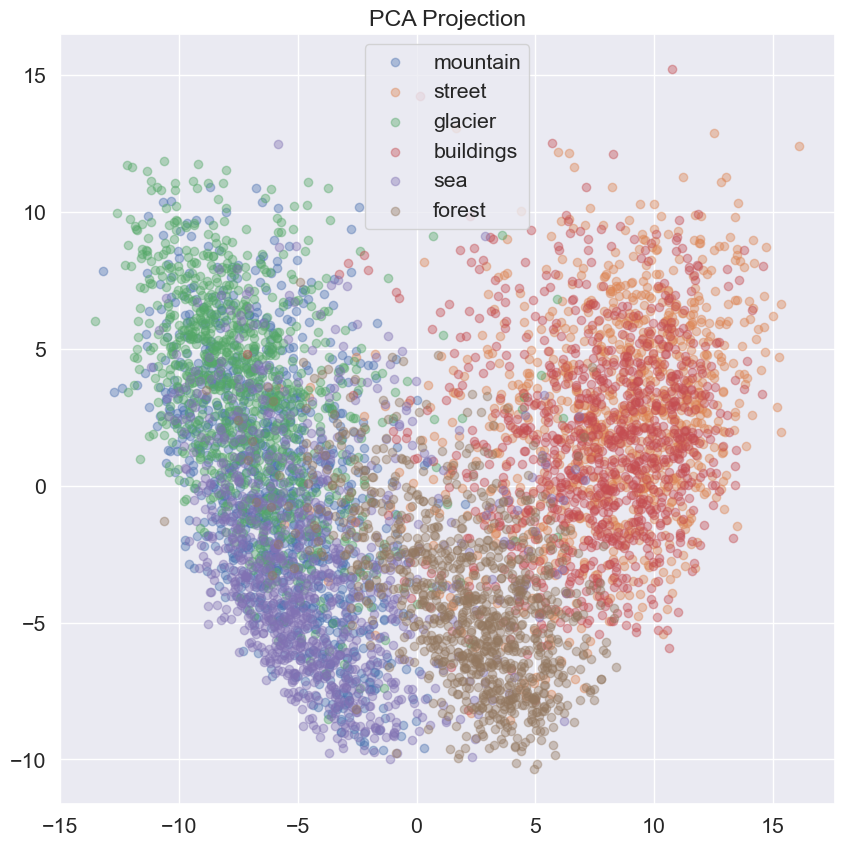

In [25]:
## PLOTTING CLUSTERS
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

Implementação inicial da CNN com o modelo VGG e TensorFlow Keras API

Primeira camada, de input dos dados, de acordo com a dimensão x,y,z.
Em seguida, mais uma camada densamente conectada de 50 unidades e função ReLU de ativação.
Ao final, camada de output, com 6 unidades, devido as 6 categorias e função softmax para probabilidades de cada uma das categorias.

In [26]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 10ms/step - loss: 0.5028 - accuracy: 0.8154 - val_loss: 0.3576 - val_accuracy: 0.8639
Epoch 2/15
88/88 [==============================] - 1s 7ms/step - loss: 0.2976 - accuracy: 0.8937 - val_loss: 0.3415 - val_accuracy: 0.8742
Epoch 3/15
88/88 [==============================] - 1s 8ms/step - loss: 0.2375 - accuracy: 0.9159 - val_loss: 0.3259 - val_accuracy: 0.8814
Epoch 4/15
88/88 [==============================] - 0s 5ms/step - loss: 0.1899 - accuracy: 0.9348 - val_loss: 0.3241 - val_accuracy: 0.8789
Epoch 5/15
88/88 [==============================] - 1s 8ms/step - loss: 0.1578 - accuracy: 0.9499 - val_loss: 0.3201 - val_accuracy: 0.8846
Epoch 6/15
88/88 [==============================] - 1s 6ms/step - loss: 0.1325 - accuracy: 0.9583 - val_loss: 0.3348 - val_accuracy: 0.8807
Epoch 7/15
88/88 [==============================] - 0s 5ms/step - loss: 0.1301 - accuracy: 0.9578 - val_loss: 0.3410 - val_accuracy: 0.8746
Epoch 8/15
88/88 [=

Avaliação de desempenho, após implementação inicial do VGG

Pode-se verificar que, em relação ao resultado inicial, com a CNN básica, 

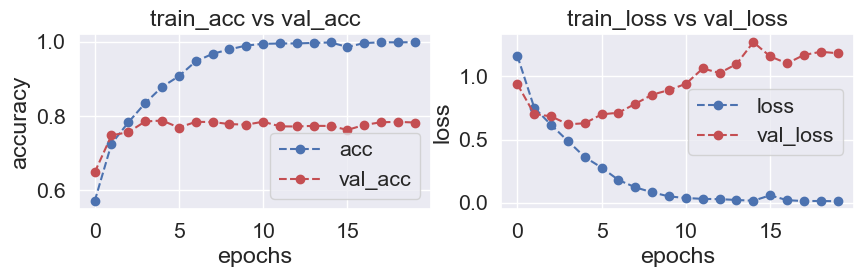

In [27]:
plot_accuracy_loss(history)

Melhoria mínima, em comparação com o modelo base, do início do notebook, tivemos aproximadamente 79% de acerto, contra 86% contra o modelo VGG básico.

In [28]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.8690


Ensemble Neural Networks

- O que é:
Em seguida, com o objetivo de aumentar e reforçar robustez da análise, aplicamos uma técnica em que utilizamos múltiplas redes neurais, combinadas e com dados diversos. Utilizamos o mesmo dataset nas diversas redes neurais, e com o resultado da combinação de cada uma das predições, podemos analisar o resultado final.
Essa técnica pode reduzir o impacto de modelos enviesados ou com erro.

In [29]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [30]:
models = list() 
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [31]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
79/79 [==============================] - 1s 10ms/step - loss: 0.5587 - accuracy: 0.7953 - val_loss: 0.3329 - val_accuracy: 0.8851
Epoch 2/10
79/79 [==============================] - 0s 6ms/step - loss: 0.2742 - accuracy: 0.9024 - val_loss: 0.2458 - val_accuracy: 0.9163
Epoch 3/10
79/79 [==============================] - 0s 6ms/step - loss: 0.1898 - accuracy: 0.9376 - val_loss: 0.2167 - val_accuracy: 0.9288
Epoch 4/10
79/79 [==============================] - 1s 7ms/step - loss: 0.1464 - accuracy: 0.9541 - val_loss: 0.2121 - val_accuracy: 0.9261
Epoch 5/10
79/79 [==============================] - 0s 5ms/step - loss: 0.1159 - accuracy: 0.9655 - val_loss: 0.1929 - val_accuracy: 0.9394
Epoch 6/10
79/79 [==============================] - 1s 7ms/step - loss: 0.0919 - accuracy: 0.9766 - val_loss: 0.1964 - val_accuracy: 0.9368
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0705 - accuracy: 0.9832 - val_loss: 0.2133 - val_accuracy: 0.9288
Epoch 8/10
79/79 [=

Após 10 iterações (loop) com 10 modelos diferentes, realizamos a compilação dos resultados, e verifica-se um aumento de aproximadamente 2% em relação ao VGG aplicado inicialmente, somente uma iteração.

In [32]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

94/94 [==============================] - 0s 3ms/step


Avaliação de desempenho, com 10 iterações = 86%

In [33]:
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8866666666666667


Fine Tunning - VGG & ImageNET

Com o objetivo de aumentar ainda mais performance, realizaremos o fine tunning do resultado obtido até o momento com a utilização de mais um recurso: ImageNET

- O que é:
Base de dados de larga escala, focada na aplicação de reconhecimento de objetivos e computação visual. Contém milhões de imagens, previamente treinadas em aproximadamente 20 mil categorias diferentes. Esse é um recurso muito útil, basicamente um compilado, que em condições normais, levaria tempo considerável para se treinar e classificar.

In [34]:
# model configuration
model = VGG16(weights='imagenet', include_top=False) #initializing our model with pre-trained weights from ImageNET dataset
model = Model(inputs=model.inputs, outputs=model.layers[-5].output) #truncates the VGG16 model and creates a new model that outputs the activations of the chosen layer.

In [35]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 101s 1s/step


Em seguida, modificaremos o roteiro de utilização do modelo VGG, para adição das informações pré-treinadas (ImageNET) em camadas específicas enquanto retem a base original do modelo VGG16. Portanto, modificamos o modelo VGG 16, com a adição de camadas específicas, desta forma, transferindo as informações úteis do modelo pré-treinado, em combinação com o modelo VGG e as informações do dataset da análise.

In [36]:

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [37]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
new_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 64)          0   

In [39]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 97s 1s/step - loss: 0.7622 - accuracy: 0.7155 - val_loss: 0.3630 - val_accuracy: 0.8821
Epoch 2/10
88/88 [==============================] - 94s 1s/step - loss: 0.3299 - accuracy: 0.8865 - val_loss: 0.3136 - val_accuracy: 0.8917
Epoch 3/10
88/88 [==============================] - 96s 1s/step - loss: 0.2645 - accuracy: 0.9068 - val_loss: 0.3296 - val_accuracy: 0.8860
Epoch 4/10
88/88 [==============================] - 98s 1s/step - loss: 0.2294 - accuracy: 0.9196 - val_loss: 0.2987 - val_accuracy: 0.8970
Epoch 5/10
88/88 [==============================] - 94s 1s/step - loss: 0.1847 - accuracy: 0.9341 - val_loss: 0.2742 - val_accuracy: 0.9092
Epoch 6/10
88/88 [==============================] - 93s 1s/step - loss: 0.1413 - accuracy: 0.9515 - val_loss: 0.3126 - val_accuracy: 0.9113
Epoch 7/10
88/88 [==============================] - 93s 1s/step - loss: 0.1187 - accuracy: 0.9591 - val_loss: 0.3361 - val_accuracy: 0.9020
Epoch 8/10
88/88 [==

Avaliação após fine tunning

Com a adição da técnica de combinação do modelo VGG e dados de um modelo pré-treinado, obtemos aproximadamente 90% de acerto.

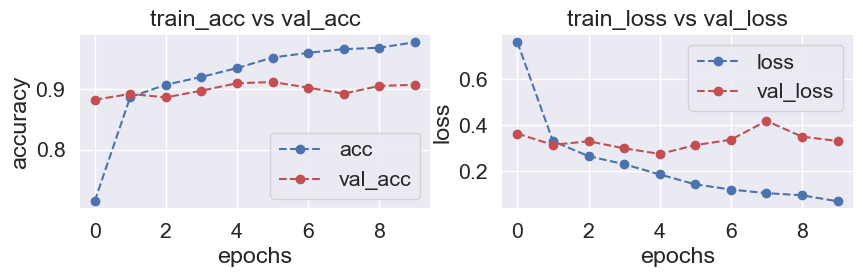

In [40]:
plot_accuracy_loss(history)

94/94 [==============================] - 7s 78ms/step
Accuracy : 0.906


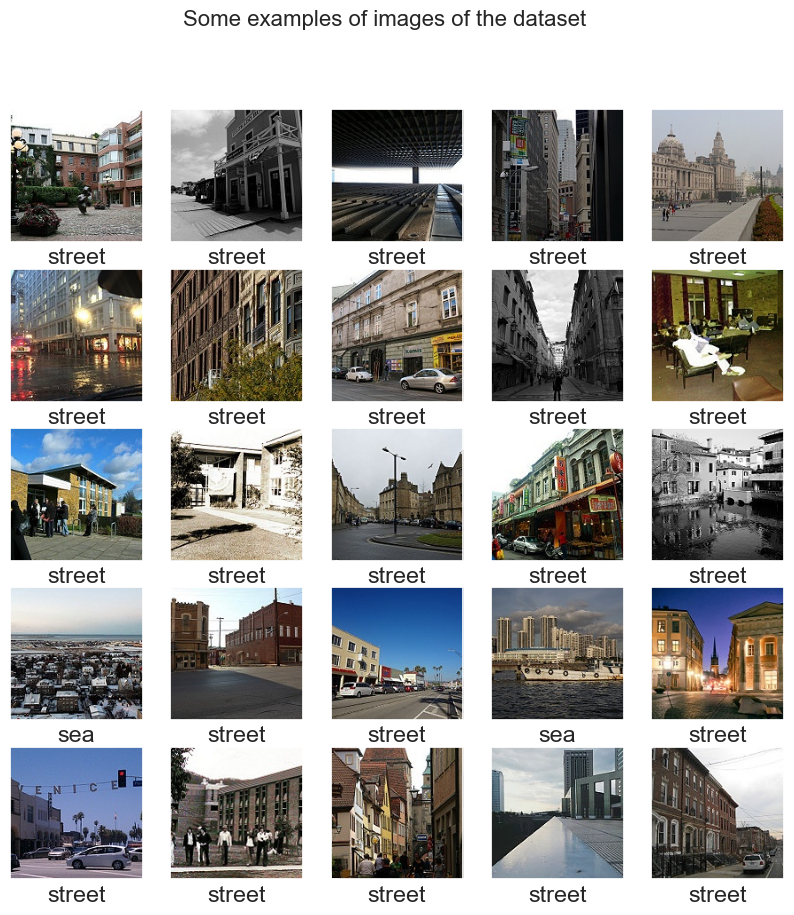

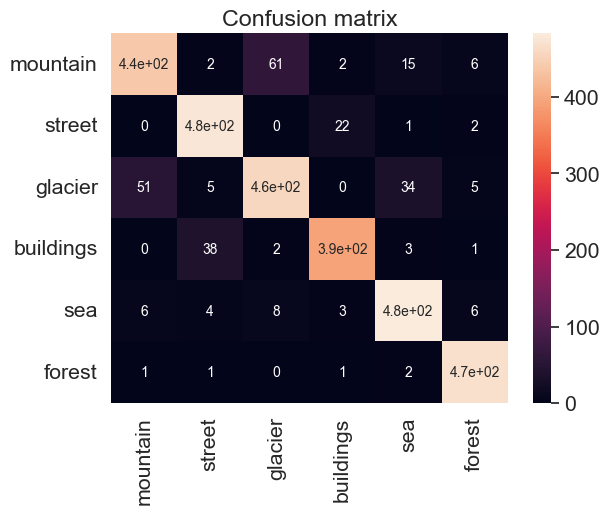

In [42]:

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
    annot_kws={"size": 10}, 
    xticklabels=class_names, 
    yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Conclusão

Em comparação com a matriz da primeira etapa (79% de acerto) contra a última implementação (90% de acerto), verifica-se uma melhoria significativa entre os dois heat maps, onde o eixo x (predição) e o eixo y (resultado verdadeiro), e isso significa diminuição de erros entre classes com overlapping.

Exemplo:
- "Street" and "building": de 89 para 38
- "glacier" and "mountain": de 80 para 51
- "glacier" and "sea": de 52 para 34

Na prática, o que muda é que o modelo é capaz de distinguir com mais eficácia imagens que possuem elementos  comuns entre categorias.

Na minha opinião, trazendo a experiência de classificação da primeira etapa do projeto, em que obtive um resultado melhor ao alterar a proporção entre conjunto de treino e teste, aumentando a quantidade do conjunto de treino e, consequentemente, o modelo obtendo mais informações sobre o conjunto de dados que recebe, percebo a mesma lógica, em proporção infinitamente maior, de se utilizar um modelo pré-treinado como o ImageNet, fornecendo experiência prévia e diversidade, para aumentar a performance da predição.

Outra técnica importante que pode ajudar na melhoria de resultados é a utilização de combinação de modelos de redes neurais, diferentes entre si, para eliminar o bias e trazer diversidade na informação. Acredito que pode-se até correlacionar com a técnica de k-fold, vista na secção de regressão, em que o dataset é dividido em sub-partes (k partes), com o objetivo de, novamente, diversificar a informação e garantir um modelo treinado com muitas informações diferentes entre si (robustez).

Extra:

A utilização de modelos treinados previamente é um recurso valioso, para a melhoria de performance, principalmente na etapa de investigação e adequação do melhor modelo para se utilizar em um determinado problema.
Assim, procurei por alternativas ao imageNet, mais utilizadas na comunidade, para ter como ferramenta útil em minhas futuras investigações de problemas relacionados a classificação e análise por imagem:

1. Xception
2. ResNet
3. InceptionV3
4. InceptionResNet
5. MobileNet
6. DenseNet
7. NasNet
